In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder , OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import joblib

In [2]:
df = pd.read_csv('../Data/featured_dataset.csv')

In [3]:
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Company                1275 non-null   category
 1   Product                1275 non-null   category
 2   TypeName               1275 non-null   category
 3   Inches                 1275 non-null   float64 
 4   CPU_Frequency (GHz)    1275 non-null   float64 
 5   RAM (GB)               1275 non-null   int64   
 6   Memory Type            1275 non-null   category
 7   Memory Capacity        1275 non-null   int64   
 8   GPU_Company            1275 non-null   category
 9   GPU_Type               1275 non-null   category
 10  OpSys                  1275 non-null   category
 11  Weight (kg)            1275 non-null   float64 
 12  Price (SAR)            1275 non-null   float64 
 13  Resolution_Width       1275 non-null   int64   
 14  Resolution_Height      1275 non-null   i

In [4]:
categorical_columns = df.select_dtypes(include='category').columns.tolist()

In [5]:
X = df.drop(columns=['Price (SAR)'])
y = df['Price (SAR)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RandomForst and Catboost

In [6]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [7]:
X_rand = df_encoded.drop(columns=['Price (SAR)'])
y_rand = df_encoded['Price (SAR)']
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_rand, y_rand, test_size=0.2, random_state=42)

In [8]:
len(df_encoded.columns)

914

In [9]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_rand, y_train_rand)

RandomForestRegressor(random_state=42)

In [10]:
y_pred_rand = rf_model.predict(X_test_rand)

In [11]:
mae_rf = mean_absolute_error(y_test_rand, y_pred_rand)
r2_rf = r2_score(y_test_rand, y_pred_rand)

In [12]:
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Mean Absolute Error (MAE): 671.26
R² Score: 0.88


In [13]:
scores_rf = cross_val_score(rf_model, X_rand, y_rand, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores_rf)
print("Average R²:", scores_rf.mean())

Cross-Validation R² Scores: [0.86829122 0.88147989 0.84387346 0.80366421 0.76335511]
Average R²: 0.832132777393278


### **Performance Comparison (Before vs. After Feature Engineering)**

| **Metric**             | **Before**        | **After**         | **Improvement** |
|----------------------|---------------------|-------------------|------------------|
| **Mean Absolute Error (MAE)** | 677.14 SAR        | **671.26 SAR**   | **↓ 5.88 SAR**   |
| **Test R² Score**        | 0.87               | **0.88**         | **↑ 0.01**       |
| **Cross-Validation R²** | 0.81               | **0.83**         | **↑ 0.02**       |

---

### **Key Insights**
1. **Better Predictions**:
   - The lower MAE indicates better overall prediction accuracy after feature engineering.

2. **Improved Model Generalization**:
   - Cross-validation **R²** increased from **0.81** to **0.83**, showing more consistent model performance.

3. **Why This Happened**:
   - **Better Features**:
     - Adding `PPI`, `ScreenWidth`, and `ScreenHeight` improved screen resolution representation.
     - Extracting `CPU_Simplified`, `GPU_Simplified`, and splitting `Memory_SSD` and `Memory_HDD` added meaningful features.
   - **Scaling and Encoding**:
     - Scaling numeric features and encoding categorical values allowed better tree splits.

In [14]:
best_model_cat = CatBoostRegressor(
    depth=6, 
    learning_rate=0.05, 
    iterations=1500, 
    random_state=42, 
    task_type="GPU", 
    cat_features=categorical_columns, 
    devices='0:1',
    verbose=0
)

In [15]:
best_model_cat.fit(X_train, y_train)

In [16]:
y_hat_best = best_model_cat.predict(X_test)

In [17]:
mae_bt = mean_absolute_error(y_test, y_hat_best)
r2_bt = r2_score(y_test, y_hat_best)

In [18]:
print(f"Mean Absolute Error (MAE): {mae_bt:.2f}")
print(f"R² Score: {r2_bt:.2f}")

Mean Absolute Error (MAE): 680.65
R² Score: 0.88


In [19]:
scores_cat = cross_val_score(best_model_cat, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores_cat)
print("Average R²:", scores_cat.mean())

Cross-Validation R² Scores: [0.88768575 0.90033824 0.85026048 0.79876993 0.76398417]
Average R²: 0.8402077147137454


### **Performance Comparison: CatBoost Before vs. After Feature Engineering**

| **Metric**              | **Before**        | **After**         | **Improvement** |
|------------------------|---------------------|-------------------|------------------|
| **Mean Absolute Error (MAE)** | 680.36 SAR        | **680.65 SAR**   | **↔️ Slight Increase**   |
| **Test R² Score**        | 0.87               | **0.88**         | **↑ 0.01**       |
| **Cross-Validation R²** | 0.84               | **0.84**         | **↑ 0.002**      |

---

### **Key Insights**
1. **Slight Performance Gain**:
   - The MAE remained almost the same, with a **minor increase** due to more complex features.
   - The **Test R² Score** increased from **0.87 to 0.88**, showing a slight improvement.

2. **Cross-Validation Consistency**:
   - Cross-validation **R² increased** from **0.8379 to 0.8402**, indicating better generalization.

3. **Possible Cause of the MAE Increase**:
   - **More Features, Higher Complexity**:
     - While the additional features improved the model's generalization (higher R²), slight overfitting on training data may have led to an increased MAE.

---

In [20]:
# ---

### **Performance Comparison Table**
| **Metric**              | **Random Forest** | **CatBoost Regressor** |
|------------------------|---------------------|--------------------------|
| **Mean Absolute Error (MAE)** | **671.26 SAR**     | 680.65 SAR              |
| **Test R² Score**        | **0.88**            | **0.88**                |
| **Cross-Validation R²** | **0.83**            | **0.84**                |
| **Training Speed**       | Faster (CPU)        | Slower (GPU-optimized)  |
| **Model Complexity**     | Simpler             | Advanced (Boosting)     |
| **Handling Missing Data** | No (Manual Needed) | **Yes (Native Support)** |
| **Categorical Support**  | No (Encoding Needed)| **Yes (Built-in)**      |

---

### **Key Insights**
1. **Best for Accuracy**:
   - Both models have a high **R² Score (0.88)** and similar performance in **cross-validation**, making them **equally accurate**.

2. **Best for Simplicity**:
   - **Random Forest** is simpler and faster to train.
   - Requires **manual encoding** of categorical features.

3. **Best for Robustness and Scaling**:
   - **CatBoost** supports:
     - **Native categorical encoding**.
     - **GPU acceleration** for large datasets.
     - **Missing value handling** (automatic).

---

### **Best Choice by Use Case**
| **Scenario**                   | **Best Model**         | **Reason**                |
|-------------------------------|-------------------------|----------------------------|
| **Small-Medium Data (CPU)**    | **Random Forest**      | Faster, simpler training  |
| **Large Data (GPU Available)** | **CatBoost Regressor** | Built-in GPU support      |
| **Deployment Simplicity**      | **Random Forest**      | No special libraries      |
| **Best Generalization**        | **CatBoost Regressor** | Higher CV R² & native encoding |

---

## Preporcessing

In [21]:
df.head()

,Company,Product,TypeName,Inches,CPU_Frequency (GHz),RAM (GB),Memory Type,Memory Capacity,GPU_Company,GPU_Type,...,Contains_4K,Contains_Quad_HD_plus,CPU_Family,CPU_Generation,CPU_Series,GPU_Family,GPU_Series,GPU_Series_Clean,Series_Type,Performance_Tier
0,Apple,MacBook Pro,Ultrabook,13.3,2.3,8,SSD,128,Intel,Iris Plus Graphics 640,...,0,0,Core,7,i5,Iris,640,640,Numeric,Mid-Range
1,Apple,Macbook Air,Ultrabook,13.3,1.8,8,Flash,128,Intel,HD Graphics 6000,...,0,0,Core,7,i5,HD,6000,6000,Numeric,High-End
2,HP,250 G6,Notebook,15.6,2.5,8,SSD,256,Intel,HD Graphics 620,...,0,0,Core,7,i5,HD,620,620,Numeric,Mid-Range
3,Apple,MacBook Pro,Ultrabook,15.4,2.7,16,SSD,512,AMD,Radeon Pro 455,...,0,0,Core,7,i7,Radeon,455,455,Numeric,Low-End
4,Apple,MacBook Pro,Ultrabook,13.3,3.1,8,SSD,256,Intel,Iris Plus Graphics 650,...,0,0,Core,7,i5,Iris,650,650,Numeric,Mid-Range


In [22]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

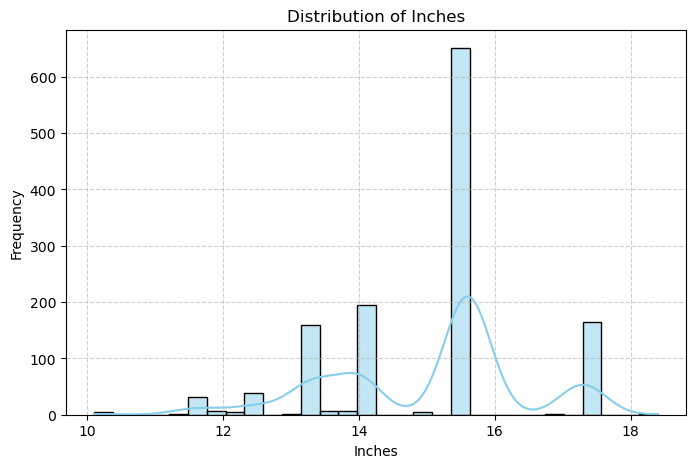

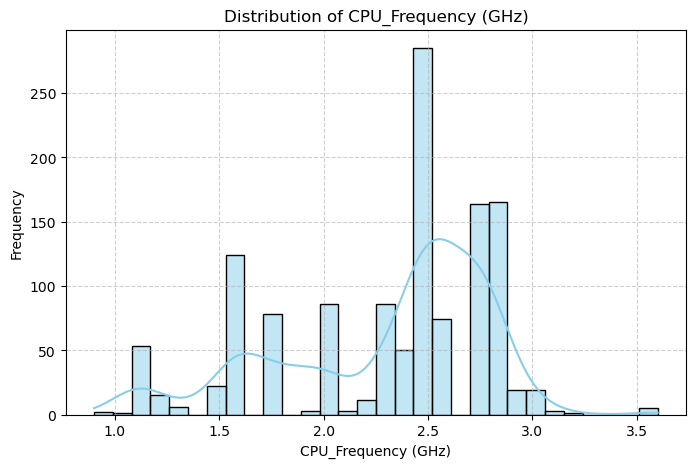

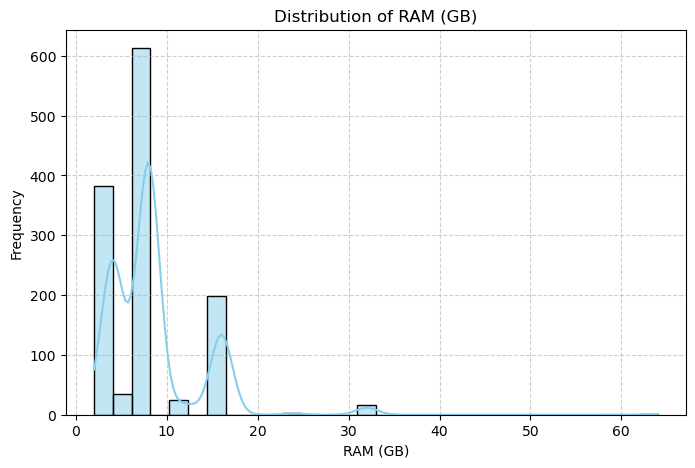

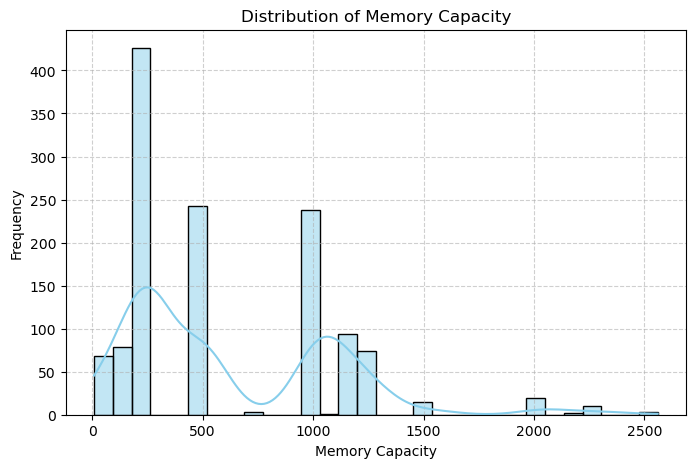

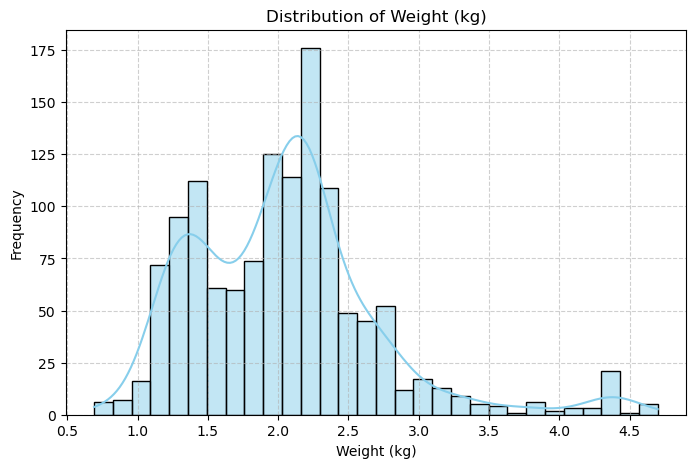

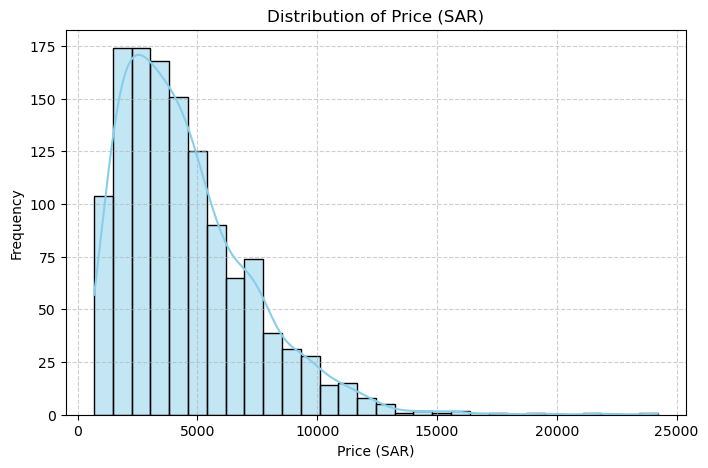

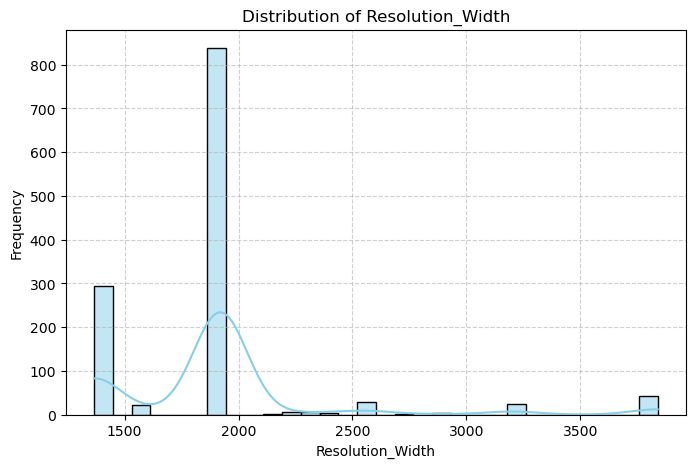

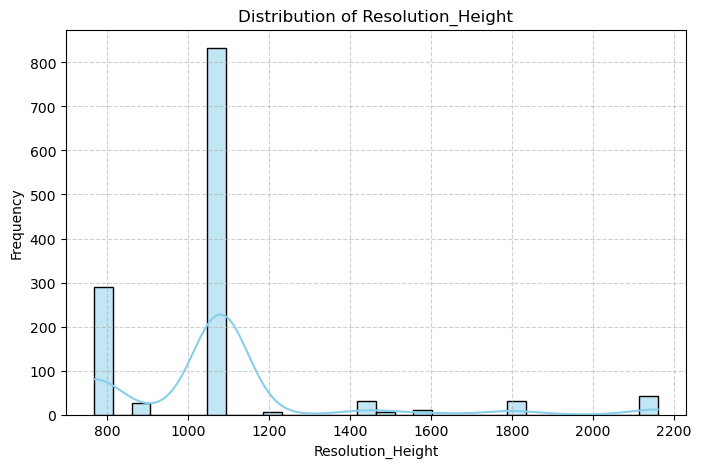

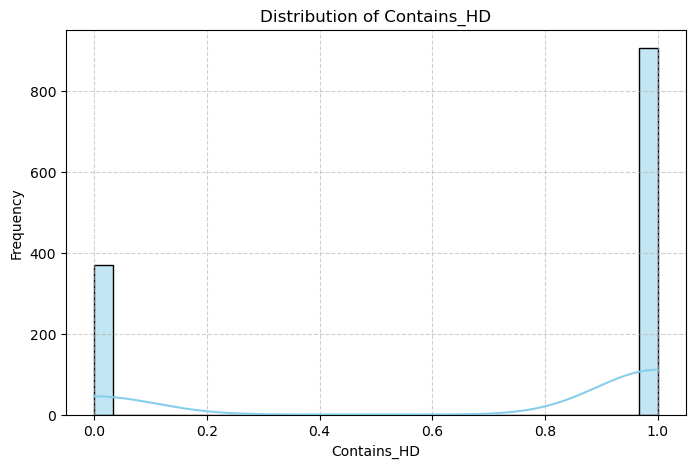

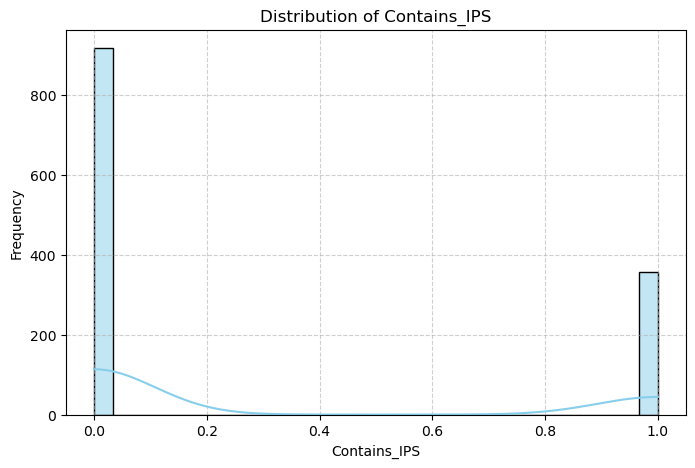

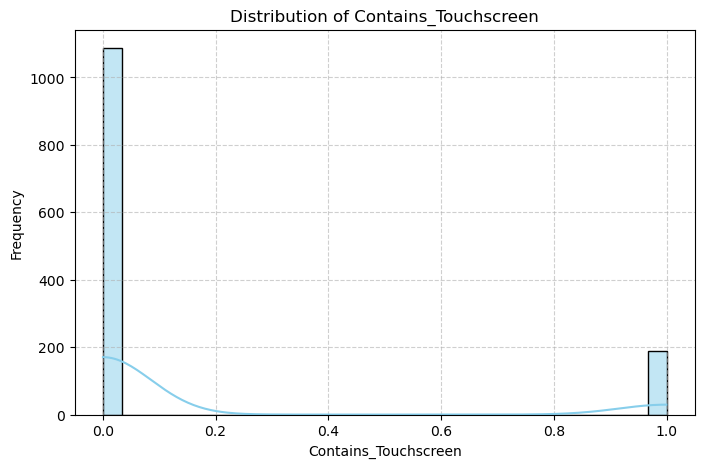

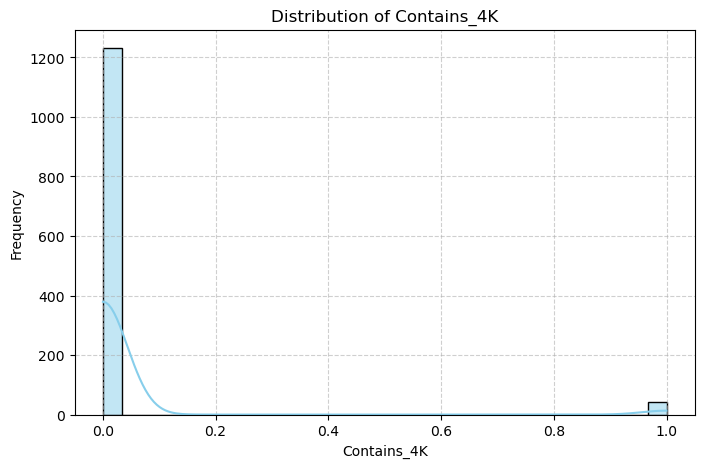

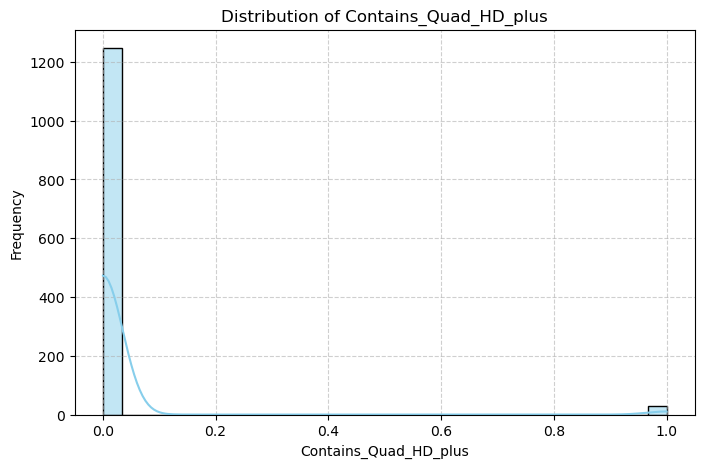

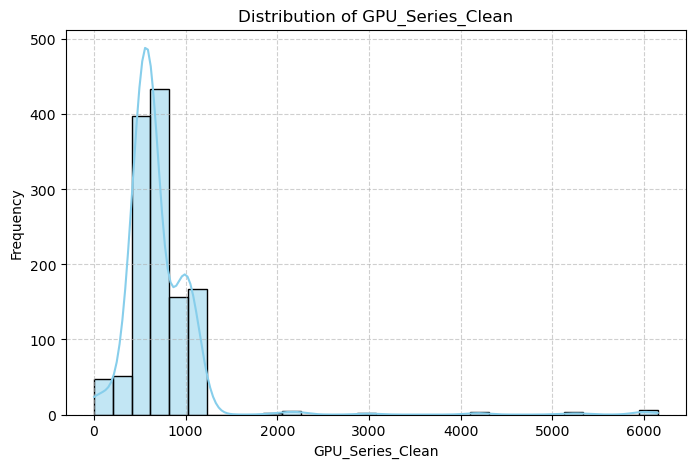

In [23]:
for col in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

In [24]:
iqr_values = {}

for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_values[col] = IQR

iqr_df = pd.DataFrame(list(iqr_values.items()), columns=['Column', 'IQR'])
iqr_df

,Column,IQR
0,Inches,1.600
1,CPU_Frequency (GHz),0.700
2,RAM (GB),4.000
3,Memory Capacity,768.000
4,Weight (kg),0.810
5,Price (SAR),3523.375
6,Resolution_Width,0.000
7,Resolution_Height,0.000
8,Contains_HD,1.000
9,Contains_IPS,1.000


### **Key Insights from IQR Analysis**
1. **High IQR (Potential Variability)**:
   - **`Memory Capacity (768.0)`**, **`Price (SAR) (3523.375)`**, **`GPU_Series_Clean (410.0)`**:
     - These features have a **high IQR**, indicating significant variability. Consider:
       - **Log Transformation** (for price).
       - **Scaling** or **normalization** for these features.

2. **Zero IQR (Low Variability)**:
   - **`Resolution_Width`**, **`Resolution_Height`**, **`Contains_Touchscreen`**, **`Contains_4K`**, **`Contains_Quad_HD_plus`**:
     - **Zero IQR** suggests that these columns might be **constant** or have minimal variance.
     - Consider **dropping them** if they **don’t contribute** to prediction performance.

3. **Binary Features (IQR = 1)**:
   - **`Contains_HD`**, **`Contains_IPS`**:
     - These are likely **binary features** (`0` or `1`).
     - No further scaling or transformation is needed.

4. **Moderate IQR (Consider Scaling)**:
   - **`Inches (1.6)`**, **`CPU_Frequency (0.7)`**, **`RAM (GB) (4.0)`**, **`Weight (kg) (0.81)`**:
     - Consider **MinMax Scaling** or **Standardization** to **normalize the range**.

---

In [25]:
for col in ['Memory Capacity', 'GPU_Series_Clean']:
       Q1 = df[col].quantile(0.25)
       Q3 = df[col].quantile(0.75)
       IQR = Q3 - Q1
       lower_bound = Q1 - 1.5 * IQR
       upper_bound = Q3 + 1.5 * IQR
       df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [26]:
iqr_values = {}

for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_values[col] = IQR

iqr_df = pd.DataFrame(list(iqr_values.items()), columns=['Column', 'IQR'])
iqr_df

,Column,IQR
0,Inches,1.60
1,CPU_Frequency (GHz),0.70
2,RAM (GB),4.00
3,Memory Capacity,768.00
4,Weight (kg),0.80
5,Price (SAR),3497.57
6,Resolution_Width,320.00
7,Resolution_Height,180.00
8,Contains_HD,1.00
9,Contains_IPS,1.00


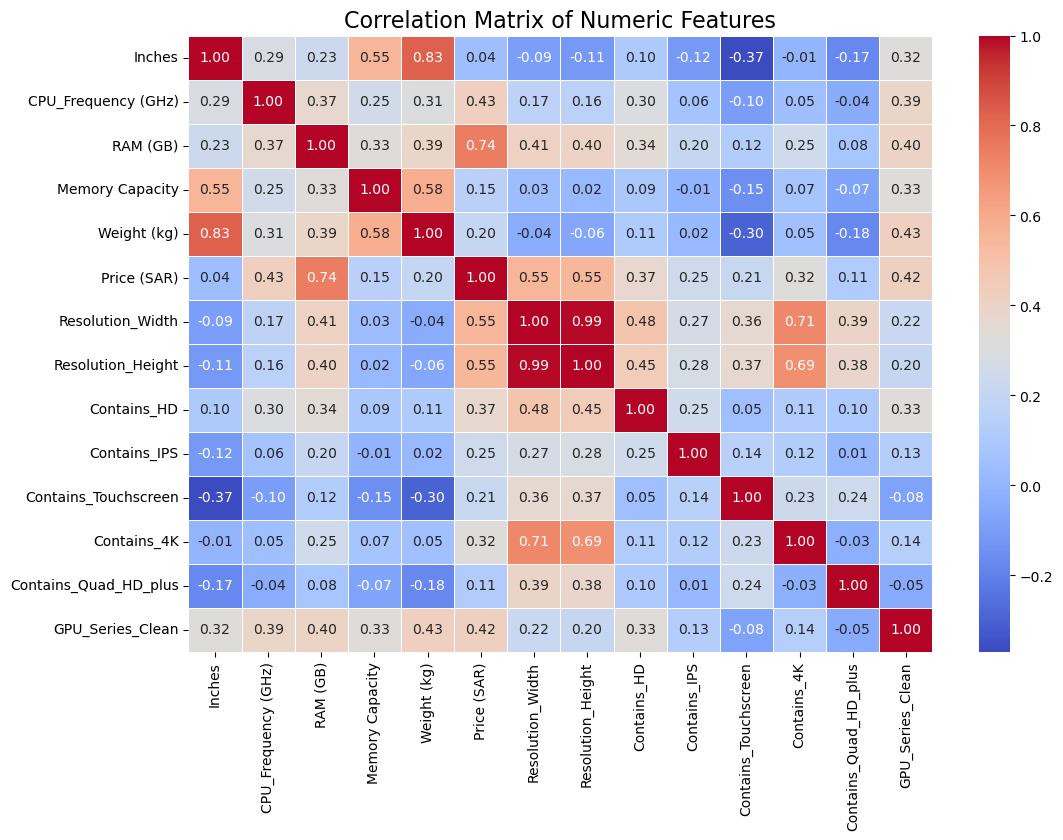

In [27]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# numerical_columns.append('Price (SAR)')
corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

In [28]:
threshold = 0.85
high_corr_features = [
    (col1, col2)
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold
]
high_corr_features

[('Resolution_Width', 'Resolution_Height'),
 ('Resolution_Height', 'Resolution_Width')]

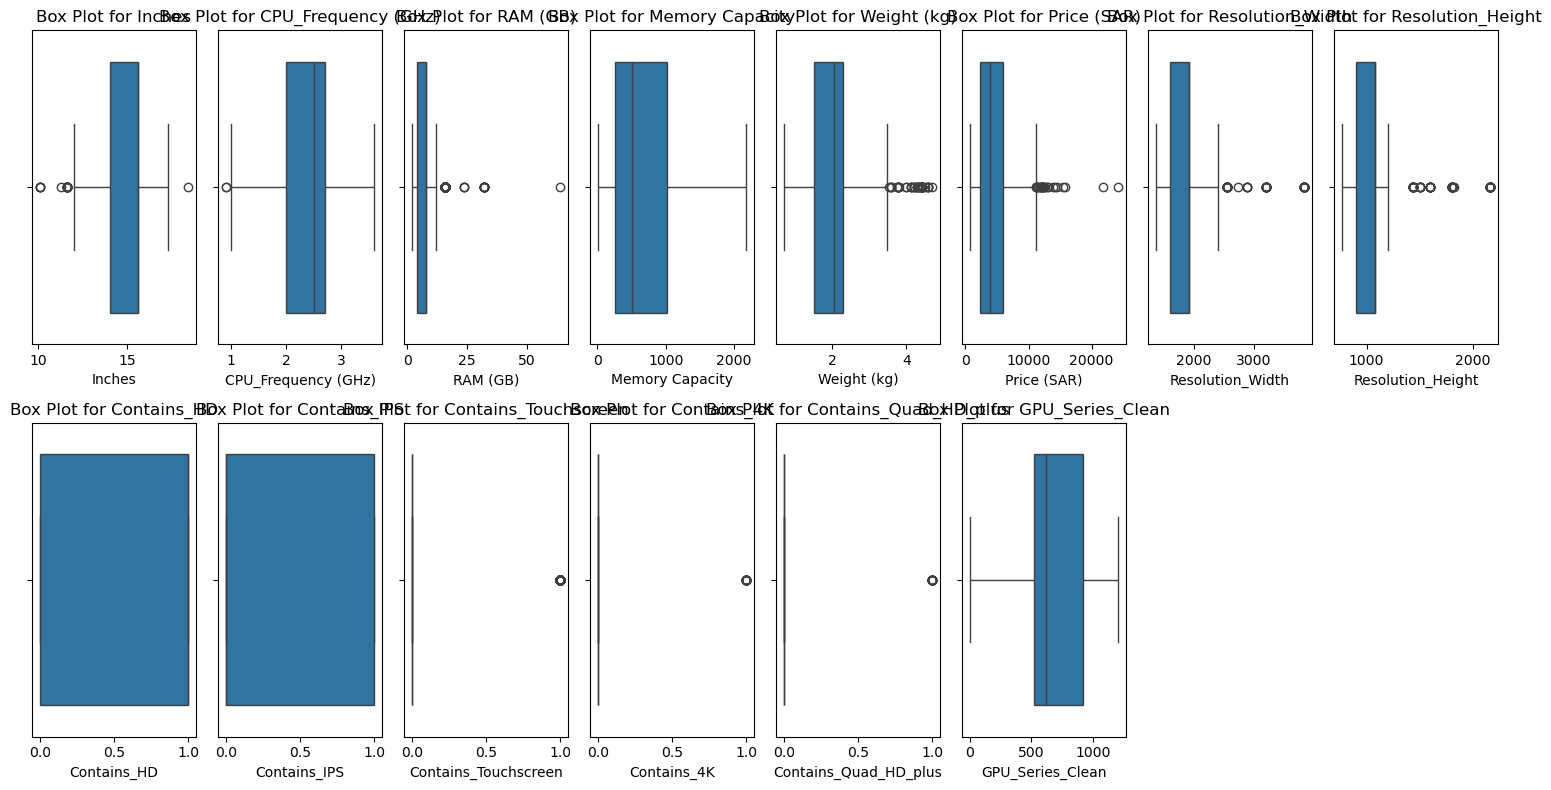

In [29]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns) // 2 + 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot for {col}')
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df[numerical_columns]))
outliers_z = (z_scores > 3).any(axis=1)  # Threshold = 3

In [31]:
# IQR Method
outliers_iqr = []
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_col = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    outliers_iqr.append(outliers_col.sum())

In [32]:
print("Outliers Summary:")
print("Z-score Method:", outliers_z.sum())
print()
for col, count in zip(numerical_columns, outliers_iqr):
    print(f"{col}: {count} (IQR Method)")

Outliers Summary:
Z-score Method: 124

Inches: 36 (IQR Method)
CPU_Frequency (GHz): 2 (IQR Method)
RAM (GB): 202 (IQR Method)
Memory Capacity: 0 (IQR Method)
Weight (kg): 46 (IQR Method)
Price (SAR): 25 (IQR Method)
Resolution_Width: 96 (IQR Method)
Resolution_Height: 112 (IQR Method)
Contains_HD: 0 (IQR Method)
Contains_IPS: 0 (IQR Method)
Contains_Touchscreen: 186 (IQR Method)
Contains_4K: 37 (IQR Method)
Contains_Quad_HD_plus: 28 (IQR Method)
GPU_Series_Clean: 0 (IQR Method)


---

## Preprocessing 

**You can share your thoughts on data preprocessing here.**

In [134]:
df_train = df.copy()

### 1. **Check Feature Distribution** (to understand data shape).  

In [135]:
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).drop('Price (SAR)', axis=1).columns

In [136]:
from scipy.stats import skew

skewness = df_train[numerical_columns].apply(skew).sort_values(ascending=False)
print("Feature Skewness:\n", skewness)

Feature Skewness:
 Contains_Quad_HD_plus    6.429970
Contains_4K              5.529129
RAM (GB)                 2.794081
Resolution_Width         2.196074
Resolution_Height        2.103774
Contains_Touchscreen     1.961720
Weight (kg)              1.184314
Contains_IPS             0.977645
Memory Capacity          0.810407
GPU_Series_Clean         0.197644
Inches                  -0.428870
CPU_Frequency (GHz)     -0.846887
Contains_HD             -0.916520
dtype: float64


Your **skewness results** indicate several features with high positive skewness. Here’s a breakdown and recommended next steps:

---

#### **Key Observations**
#### **Highly Skewed Features (Skewness > 2)**:
- **Severely Skewed**:
  - `Contains_Quad_HD_plus` (6.43)
  - `Contains_4K` (5.53)
  - `RAM (GB)` (2.79)

#### **Moderately Skewed (1 < Skewness < 2)**:
- `Resolution_Width` (2.19)
- `Resolution_Height` (2.10)
- `Contains_Touchscreen` (1.96)
- `Price (SAR)` (1.44)
- `Weight (kg)` (1.18)

#### **Nearly Normal (-1 < Skewness < 1)**:
- `Memory Capacity` (0.81)
- `GPU_Series_Clean` (0.19)
- `Inches` (-0.43)

#### **Negatively Skewed (Skewness < -1)**:
- `CPU_Frequency (GHz)` (-0.85)
- `Contains_HD` (-0.91)

---

1. **Apply Log Transformation** for **highly skewed features** (skewness > 2).  
2. **Consider Capping or Scaling** for moderately skewed features.  
3. **Leave Nearly Normal Features As-Is**.

---

In [137]:
skewed_features = ['Contains_Quad_HD_plus', 'Contains_4K', 'RAM (GB)', 
                   'Resolution_Width', 'Resolution_Height', 'Contains_Touchscreen']

for col in skewed_features:
    df_train[col] = np.log1p(df_train[col])

### 2. **Check Multicollinearity** (to identify highly correlated features).  

In [138]:
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).drop('Price (SAR)', axis=1).columns

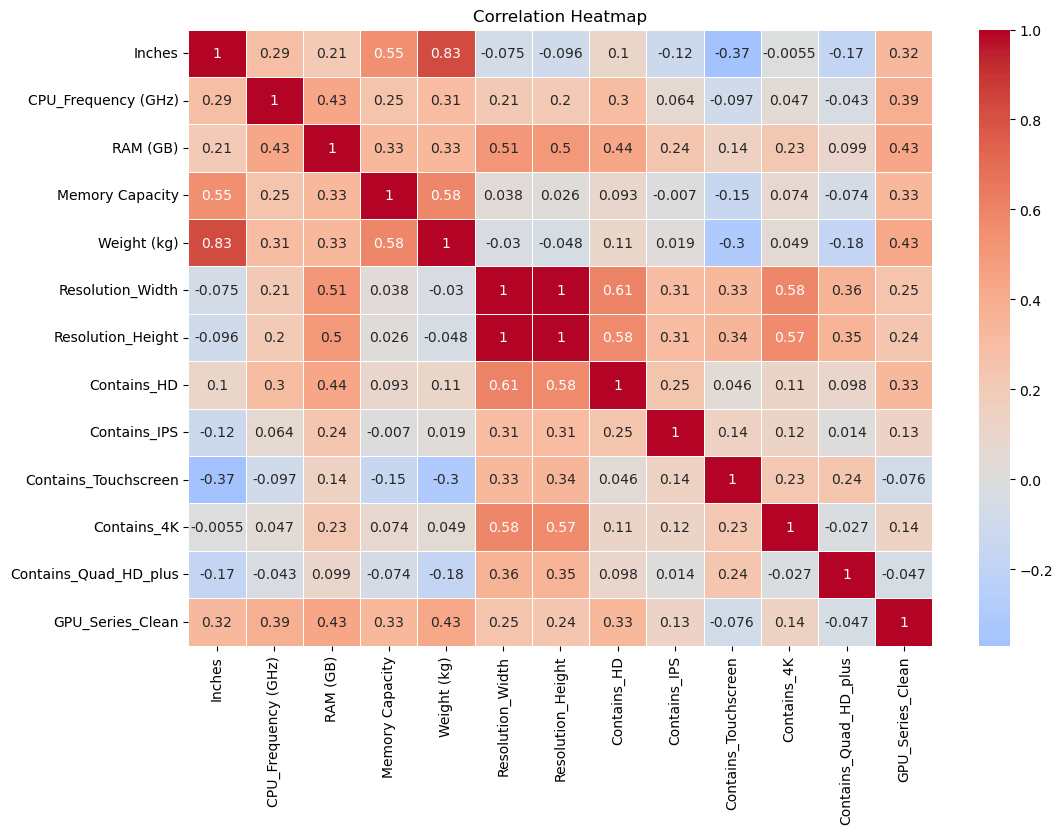

In [139]:
correlation_matrix = df_train[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [141]:
# Standardize numerical features
X_scaled = StandardScaler().fit_transform(df_train[numerical_columns])

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]


In [142]:
vif_data

,Feature,VIF
0,Inches,3.696440
1,CPU_Frequency (GHz),1.387451
2,RAM (GB),1.956638
3,Memory Capacity,1.640552
4,Weight (kg),3.953891
5,Resolution_Width,235.506816
6,Resolution_Height,193.683209
7,Contains_HD,3.339655
8,Contains_IPS,1.206576
9,Contains_Touchscreen,1.370695


In [143]:
df_train['Pixel_Area'] = df_train['Resolution_Width'] * df_train['Resolution_Height']

In [144]:
df_train.drop(['Resolution_Width', 'Resolution_Height'], axis=1, inplace=True)

### 3. **Detect and Handle Outliers** (to remove data points that negatively impact the model).  

In [145]:
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).drop('Price (SAR)', axis=1).columns

In [146]:
for col in numerical_columns:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Inches: 0
Outliers in CPU_Frequency (GHz): 0
Outliers in RAM (GB): 1
Outliers in Memory Capacity: 0
Outliers in Weight (kg): 1
Outliers in Contains_HD: 0
Outliers in Contains_IPS: 0
Outliers in Contains_Touchscreen: 186
Outliers in Contains_4K: 37
Outliers in Contains_Quad_HD_plus: 28
Outliers in GPU_Series_Clean: 0
Outliers in Pixel_Area: 37


The value **1.5** is used in the **Interquartile Range (IQR) Method** as a standard threshold to detect **mild outliers**. This threshold is based on statistical conventions in data analysis.

---

#### **Why Use 1.5 in the IQR Method?**  

The IQR method defines **outlier boundaries** using this formula:

$
\text{Lower Bound} = Q1 - 1.5 \times \text{IQR}
$
$
\text{Upper Bound} = Q3 + 1.5 \times \text{IQR}
$

Where:  
- **Q1 (25th percentile)**: The value below which 25% of the data falls.  
- **Q3 (75th percentile)**: The value below which 75% of the data falls.  
- **IQR (Interquartile Range)**: The range between Q3 and Q1:  
  $
  \text{IQR} = Q3 - Q1
  $

---

#### **Why is 1.5 Chosen?**  
- **Statistics Theory**:  
  In a normal distribution, approximately **99.3%** of data points fall within **1.5 × IQR** from Q1 and Q3. Data points outside this range are considered outliers.  

- **Robust to Non-Normal Distributions**:  
  Unlike standard deviation-based methods, IQR works well even if the data is **skewed** or **non-normal**.  

---

#### **Alternatives to 1.5**  
1. **Mild Outliers**: Use **1.5 × IQR** (common practice).  
2. **Extreme Outliers**: Use **3 × IQR** (for stricter outlier detection).  

---

#### **Example**  
Suppose the data for a feature looks like this:  
$
Q1 = 1000, \quad Q3 = 3000, \quad IQR = Q3 - Q1 = 2000
$

The **outlier boundaries** would be:

$
\text{Lower Bound} = Q1 - 1.5 \times 2000 = 1000 - 3000 = -2000
$
$
\text{Upper Bound} = Q3 + 1.5 \times 2000 = 3000 + 3000 = 6000
$

- Any value **below -2000** or **above 6000** would be flagged as an outlier.

---

#### **When to Use a Different Threshold?**
- Use **1.5 × IQR** if you want to detect **most outliers**.  
- Use **3 × IQR** if you only want to detect **extreme outliers**.  

---

1. **Minimal or No Outliers**:
   - `Inches`, `CPU_Frequency (GHz)`, `Memory Capacity`, `Contains_HD`, `Contains_IPS`, `GPU_Series_Clean` – **No action needed.**  

2. **Few Outliers (1-37)**:
   - `RAM (GB)` (1 outlier)  
   - `Weight (kg)` (1 outlier)  
   - `Contains_4K` (37 outliers)  
   - `Pixel_Area` (37 outliers)  

3. **Many Outliers (186)**:
   - `Contains_Touchscreen` (186 outliers): This suggests an imbalanced distribution, likely due to this being a **binary feature** with rare values.

---



#### **1. Capping Numerical Outliers**  
For numerical features (`RAM (GB)`, `Weight (kg)`, `Pixel_Area`), we can **cap outliers** to the upper and lower bounds using the 3×IQR method.

In [147]:
outlier_features = ['RAM (GB)', 'Weight (kg)', 'Pixel_Area']

for col in outlier_features:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Cap values to bounds
    df_train[col] = df_train[col].clip(lower=lower_bound, upper=upper_bound)

In [148]:
for col in numerical_columns:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Inches: 0
Outliers in CPU_Frequency (GHz): 0
Outliers in RAM (GB): 0
Outliers in Memory Capacity: 0
Outliers in Weight (kg): 0
Outliers in Contains_HD: 0
Outliers in Contains_IPS: 0
Outliers in Contains_Touchscreen: 186
Outliers in Contains_4K: 37
Outliers in Contains_Quad_HD_plus: 28
Outliers in GPU_Series_Clean: 0
Outliers in Pixel_Area: 0


In [149]:
binary_features = ['Contains_Touchscreen', 'Contains_4K']

for col in binary_features:
    print(f"{col} Distribution:")
    print(df_train[col].value_counts(normalize=True) * 100)
    print("-" * 40)

Contains_Touchscreen Distribution:
Contains_Touchscreen
0.000000    85.012087
0.693147    14.987913
Name: proportion, dtype: float64
----------------------------------------
Contains_4K Distribution:
Contains_4K
0.000000    97.018533
0.693147     2.981467
Name: proportion, dtype: float64
----------------------------------------


## Train Model

**"Train the model on your preprocessed data and evaluate whether it performs better."**

| **Metric**              | **Random Forest** | **CatBoost Regressor** |
|------------------------|---------------------|--------------------------|
| **Mean Absolute Error (MAE)** | **671.26 SAR**     | **680.65 SAR**              |
| **Test R² Score**        | **0.88**            | **0.88**                |
| **Cross-Validation R²** | **0.83**            | **0.84**                |

In [150]:
X = df_train.drop(columns=['Price (SAR)'])
y = df_train['Price (SAR)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **CatBoost**

In [151]:
categorical_columns = df_train.select_dtypes(include='category').columns.tolist()

In [152]:
best_model_cat = CatBoostRegressor(
    depth=6, 
    learning_rate=0.05, 
    iterations=1500, 
    random_state=42, 
    task_type="GPU", 
    cat_features=categorical_columns, 
    devices='0:1',
    verbose=0
)

In [153]:
best_model_cat.fit(X_train, y_train)

In [154]:
y_hat_best = best_model_cat.predict(X_test)

In [155]:
mae_bt = mean_absolute_error(y_test, y_hat_best)
r2_bt = r2_score(y_test, y_hat_best)

In [156]:
print(f"Mean Absolut 'Price (SAR)', e Error (MAE): {mae_bt:.2f}")
print(f"R² Score: {r2_bt:.2f}")

Mean Absolut 'Price (SAR)', e Error (MAE): 683.13
R² Score: 0.83


In [157]:
scores_cat = cross_val_score(best_model_cat, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores_cat)
print("Average R²:", scores_cat.mean())

Cross-Validation R² Scores: [0.88431746 0.90409324 0.88609264 0.82667061 0.77920462]
Average R²: 0.8560757135932858


In [158]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [159]:
best_model_cat.fit(X_train, y_train_log)

In [160]:
cat_pred_log = best_model_cat.predict(X_test)

In [161]:
cat_pred_log[0]

8.276590367982879

In [162]:
cat_pred = np.expm1(cat_pred_log)

In [163]:
cat_pred[0]

3929.769031292994

In [164]:
print("CatBoost R² Score:", r2_score(y_test, cat_pred))
print("CatBoost MAE:", mean_absolute_error(y_test, cat_pred))

CatBoost R² Score: 0.8339318900875148
CatBoost MAE: 641.3895695351957


**RandomForest**

**`Note:`**  

You can tune the hyperparameters to achieve better performance.  

In [165]:
df_encoded = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)

In [166]:
X_rand = df_encoded.drop(columns=['Price (SAR)'])
y_rand = df_encoded['Price (SAR)']
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_rand, y_rand, test_size=0.2, random_state=42)

In [167]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_rand, y_train_rand)

RandomForestRegressor(random_state=42)

In [168]:
y_pred_rand = rf_model.predict(X_test_rand)

In [169]:
mae_rf = mean_absolute_error(y_test_rand, y_pred_rand)
r2_rf = r2_score(y_test_rand, y_pred_rand)

In [170]:
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Mean Absolute Error (MAE): 723.46
R² Score: 0.79


In [171]:
scores_rf = cross_val_score(rf_model, X_rand, y_rand, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores_rf)
print("Average R²:", scores_rf.mean())

Cross-Validation R² Scores: [0.86640845 0.87864209 0.87252835 0.80128207 0.79977731]
Average R²: 0.8437276507330935


In [173]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],              # Number of trees
    'max_depth': [10, 20, 30, 40, None],                    # Tree depth
    'min_samples_split': [2, 5, 10, 15],                   # Min samples to split
    'min_samples_leaf': [1, 2, 4, 8],                      # Min samples at leaf
    'max_features': ['auto', 'sqrt', 'log2'],              # Max features to consider
    'bootstrap': [True, False]                             # Use bootstrapping
}


In [174]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_rand, y_train_rand)

In [177]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_rand)

mae = mean_absolute_error(y_test_rand, y_pred)
r2 = r2_score(y_test_rand, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} SAR")
print(f"R² Score: {r2:.2f}")
